# Notebook 2 - SQL avec vraies bases de données
## Analyse e-commerce avec PostgreSQL en ligne




### 🎯 Objectifs pédagogiques
- Connecter Python à une vraie base de données PostgreSQL
- Écrire des requêtes SQL complexes sur des données réelles
- Implémenter des analyses RFM avec SQL
- Intégrer SQL et pandas pour des analyses avancées
- Gérer les connexions et la sécurité

### 🛍️ Contexte du projet
Vous analysez les données d'un vrai dataset e-commerce (Brazilian E-Commerce Public Dataset) hébergé sur une base PostgreSQL.

Objectif : créer une segmentation clientèle pour optimiser les campagnes marketing.


## Partie 1 : Connexion à la base de données réelle

### 🔧 Installation et configuration


# Installation des dépendances


```
pip install psycopg2-binary sqlalchemy pandas python-dotenv
```




In [2]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from sqlalchemy import text
from dotenv import load_dotenv

### 🌐 Base de données PostgreSQL gratuite (ElephantSQL)

**Option 1 : ElephantSQL (20MB gratuit)**
1. Créez un compte sur [elephantsql.com](https://www.elephantsql.com/)
2. Créez une instance "Tiny Turtle" (gratuite)
3. Récupérez vos credentials

**Option 2 : Supabase (500MB gratuit)**
1. Créez un compte sur [supabase.com](https://supabase.com/)
2. Créez un nouveau projet
3. Récupérez l'URL de connexion PostgreSQL

In [3]:
# Configuration de connexion (à adapter selon votre provider)
load_dotenv()


host = os.getenv('DB_HOST')  #  host Supabase
password = os.getenv('DB_PASSWORD')
user = os.getenv('DB_USER')
database = os.getenv('DB_DATABASE')
port = os.getenv('DB_PORT')


# Création de l'engine SQLAlchemy
connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_string)

# Test de connexion
def test_connection():
    """
    Testez votre connexion à la base

    Étapes :
    1. Utilisez pd.read_sql() pour exécuter "SELECT version()"
    2. Affichez la version PostgreSQL
    3. Gérez les erreurs de connexion
    """
    try:
        df = pd.read_sql('SELECT version();', engine)
        print('Connexion Ok | Version : ', df.iloc[0,0])
    except Exception as e:
        print(f"Erreur de connexion : {e}")
        return False
    return True
test_connection()

Connexion Ok | Version :  PostgreSQL 17.4 on aarch64-unknown-linux-gnu, compiled by gcc (GCC) 13.2.0, 64-bit


True


## Partie 2 : Import du dataset e-commerce

### 📊 Dataset Brazilian E-Commerce
Nous utilisons le célèbre dataset Olist (100k commandes réelles).

**Tables à créer :**
1. **customers** : customer_id, customer_city, customer_state
2. **orders** : order_id, customer_id, order_status, order_date, order_delivered_date
3. **order_items** : order_id, product_id, seller_id, price, freight_value
4. **products** : product_id, product_category, product_weight_g
5. **sellers** : seller_id, seller_city, seller_state

In [4]:
# Mise en DataFrame des csv
# Liste pour stockers les dataframes
df_list = {}
# Dossier avec les csv
data_folder = "data"
# Boucle sur les fichiers du dossier 
for csv in os.listdir(data_folder):
    if csv.endswith(".csv"): # Filtre les fichiers au format csv
        file_path = os.path.join(data_folder, csv)
        df = pd.read_csv(file_path) # Lecture des csv
        # Stockage dans le dictionnaire df_list
        name = os.path.splitext(csv)[0]
        df_list[name] = df
        print(f'{csv} chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes')

olist_order_payments_dataset.csv chargé : 103886 lignes, 5 colonnes
olist_order_reviews_dataset.csv chargé : 99224 lignes, 7 colonnes
olist_products_dataset.csv chargé : 32951 lignes, 9 colonnes
olist_customers_dataset.csv chargé : 99441 lignes, 5 colonnes
olist_sellers_dataset.csv chargé : 3095 lignes, 4 colonnes
olist_orders_dataset.csv chargé : 99441 lignes, 8 colonnes
olist_geolocation_dataset.csv chargé : 1000163 lignes, 5 colonnes
product_category_name_translation.csv chargé : 71 lignes, 2 colonnes
olist_order_items_dataset.csv chargé : 112650 lignes, 7 colonnes


**Tables à créer :**
1. **customers** : customer_id, customer_city, customer_state
2. **orders** : order_id, customer_id, order_status, order_date, order_delivered_date
3. **order_items** : order_id, product_id, seller_id, price, freight_value
4. **products** : product_id, product_category, product_weight_g
5. **sellers** : seller_id, seller_city, seller_state

In [4]:
### 🗃️ Création des tables SQL

def create_tables():

    drop_sql = """
    DROP TABLE IF EXISTS order_items;
    DROP TABLE IF EXISTS orders;
    DROP TABLE IF EXISTS products;
    DROP TABLE IF EXISTS customers;
    DROP TABLE IF EXISTS sellers;
    DROP TABLE IF EXISTS rm_segments;
    """
    
    create_customers = """
    CREATE TABLE IF NOT EXISTS customers (
        customer_id VARCHAR(50) PRIMARY KEY,
        customer_city VARCHAR(100),
        customer_state VARCHAR(2)
    );
    """

    create_orders = """
    CREATE TABLE IF NOT EXISTS orders (
        order_id VARCHAR(50) PRIMARY KEY,
        customer_id VARCHAR(50),
        order_status VARCHAR(20) CHECK (order_status IN (
            'created', 'shipped', 'delivered', 'canceled',
            'processing', 'invoiced', 'unavailable', 'approved'
        )),
        order_date TIMESTAMP,
        order_delivered_date TIMESTAMP,
        CONSTRAINT fk_customer FOREIGN KEY(customer_id) REFERENCES customers(customer_id)
    );
    """

    create_products = """ 
    CREATE TABLE IF NOT EXISTS products (
        product_id VARCHAR(50) PRIMARY KEY,
        product_category VARCHAR(50),
        product_weight_g NUMERIC CHECK (product_weight_g >= 0)
    );
    """

    create_sellers = """
    CREATE TABLE IF NOT EXISTS sellers (
        seller_id VARCHAR(50) PRIMARY KEY,
        seller_city VARCHAR(50),
        seller_state VARCHAR(2)
    );
    """

    create_order_items = """ 
    CREATE TABLE IF NOT EXISTS order_items (
        order_id VARCHAR(50),
        product_id VARCHAR(50),
        seller_id VARCHAR(50),
        price NUMERIC(10,2) CHECK (price >= 0),
        freight_value NUMERIC(10,2) CHECK (freight_value >= 0),
        CONSTRAINT fk_orders FOREIGN KEY(order_id) REFERENCES orders(order_id),
        CONSTRAINT fk_product FOREIGN KEY(product_id) REFERENCES products(product_id),
        CONSTRAINT fk_seller FOREIGN KEY(seller_id) REFERENCES sellers(seller_id)
    );
    """

    # Complétez pour les autres tables
    # N'oubliez pas les contraintes de clés étrangères !

    with engine.connect() as conn:
        conn.execute(text(drop_sql))
        print('Tables supprimées.')
        conn.execute(text(create_customers))
        print('Table Customers créée avec succès !')
        conn.execute(text(create_orders))
        print('Table Commandes créée avec succès !')
        conn.execute(text(create_sellers))
        print('Table Vendeurs créée avec succès !')
        conn.execute(text(create_products))
        print('Table Produits créée avec succès !')
        conn.execute(text(create_order_items))
        print('Table Order Items créée avec succès !')
        
        # Exécutez les autres CREATE TABLE
        conn.commit()
create_tables()

Tables supprimées.
Table Customers créée avec succès !
Table Commandes créée avec succès !
Table Vendeurs créée avec succès !
Table Produits créée avec succès !
Table Order Items créée avec succès !


## Traitements des données


In [5]:
# Données vendeurs
df_sellers = df_list['olist_sellers_dataset']
df_sellers.isna().sum()
df_sellers.drop(columns=['seller_zip_code_prefix'], inplace=True)
print(df_sellers.head())

                          seller_id        seller_city seller_state
0  3442f8959a84dea7ee197c632cb2df15           campinas           SP
1  d1b65fc7debc3361ea86b5f14c68d2e2         mogi guacu           SP
2  ce3ad9de960102d0677a81f5d0bb7b2d     rio de janeiro           RJ
3  c0f3eea2e14555b6faeea3dd58c1b1c3          sao paulo           SP
4  51a04a8a6bdcb23deccc82b0b80742cf  braganca paulista           SP


                            customer_id          customer_city customer_state
0      06b8999e2fba1a1fbc88172c00ba8bc7                 franca             SP
1      18955e83d337fd6b2def6b18a428ac77  sao bernardo do campo             SP
2      4e7b3e00288586ebd08712fdd0374a03              sao paulo             SP
3      b2b6027bc5c5109e529d4dc6358b12c3        mogi das cruzes             SP
4      4f2d8ab171c80ec8364f7c12e35b23ad               campinas             SP
...                                 ...                    ...            ...
99436  17ddf5dd5d51696bb3d7c6291687be6f              sao paulo             SP
99437  e7b71a9017aa05c9a7fd292d714858e8        taboao da serra             SP
99438  5e28dfe12db7fb50a4b2f691faecea5e              fortaleza             CE
99439  56b18e2166679b8a959d72dd06da27f9                 canoas             RS
99440  274fa6071e5e17fe303b9748641082c8                  cotia             SP

[99441 rows x 3 columns]


In [ ]:
# Données clients
df_customers = df_list['olist_customers_dataset']
df_customers.isna().sum()
df_customers.drop(columns=['customer_unique_id',
                           'customer_zip_code_prefix'],
                           inplace=True)
print(df_customers.head())


                        customer_id          customer_city customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7                 franca             SP
1  18955e83d337fd6b2def6b18a428ac77  sao bernardo do campo             SP
2  4e7b3e00288586ebd08712fdd0374a03              sao paulo             SP
3  b2b6027bc5c5109e529d4dc6358b12c3        mogi das cruzes             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad               campinas             SP


In [7]:
# Données objets commandés

df_order_items = df_list['olist_order_items_dataset']
df_order_items.isna().sum()
df_order_items.drop(columns=['shipping_limit_date'], inplace=True)
df_order_items.drop(columns=['order_item_id'], inplace=True)

print(df_order_items.head())

                           order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id   price  freight_value  
0  48436dade18ac8b2bce089ec2a041202   58.90          13.29  
1  dd7ddc04e1b6c2c614352b383efe2d36  239.90          19.93  
2  5b51032eddd242adc84c38acab88f23d  199.00          17.87  
3  9d7a1d34a5052409006425275ba1c2b4   12.99          12.79  
4  df560393f3a51e74553ab94004ba5c87  199.90          18.14  


In [8]:
# Dataframe Commandes
df_orders = df_list['olist_orders_dataset']
df_orders.isna().sum()

# Suppression des colonnes non-utilisées
df_orders.drop(columns=['order_approved_at', 'order_estimated_delivery_date',
                        'order_delivered_carrier_date'], inplace=True)

# Renommage de la colonne 'order_purchase_timestamp' en 'order_date'
df_orders.rename(columns={'order_purchase_timestamp': 'order_date',
                           'order_delivered_customer_date': 'order_delivered_date'},
                           inplace=True)
# missing_delivery = df_orders[df_orders["order_delivered_date"].isnull()]\
#          .groupby("order_status").size()
# print('Commandes sans date de livraison : ', missing_delivery)

# # Suppression des données manquantes dans la colonne 'order_delivered_date' 
# df_orders = df_orders[df_orders['order_delivered_date'].notnull()]

print(df_orders.head())




                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status           order_date order_delivered_date  
0    delivered  2017-10-02 10:56:33  2017-10-10 21:25:13  
1    delivered  2018-07-24 20:41:37  2018-08-07 15:27:45  
2    delivered  2018-08-08 08:38:49  2018-08-17 18:06:29  
3    delivered  2017-11-18 19:28:06  2017-12-02 00:28:42  
4    delivered  2018-02-13 21:18:39  2018-02-16 18:17:02  


In [9]:
# Données produits Produits

df_products = df_list['olist_products_dataset']
print(df_products[df_products.isnull().any(axis=1)]) # plusieurs données manquantes
df_products.rename(columns={"product_category_name": "product_category"}, inplace=True) # mise à jour du nom de colonne en vue d'un export sur la base de données crée
# Gestion des données manquantes dans la colonne 'product_category'
df_products['product_category'].fillna("uncategorized", inplace=True) 
# df_products.dropna(subset=["product_weight_g"], inplace=True)
    # Suppression des colonnes inutiles
df_products.drop(columns=[
    'product_name_lenght', 
    'product_description_lenght', 
    'product_photos_qty', 
    'product_length_cm', 
    'product_height_cm', 
    'product_width_cm'
], inplace=True)

print(df_products.head())

                             product_id product_category_name  \
105    a41e356c76fab66334f36de622ecbd3a                   NaN   
128    d8dee61c2034d6d075997acef1870e9b                   NaN   
145    56139431d72cd51f19eb9f7dae4d1617                   NaN   
154    46b48281eb6d663ced748f324108c733                   NaN   
197    5fb61f482620cb672f5e586bb132eae9                   NaN   
...                                 ...                   ...   
32515  b0a0c5dd78e644373b199380612c350a                   NaN   
32589  10dbe0fbaa2c505123c17fdc34a63c56                   NaN   
32616  bd2ada37b58ae94cc838b9c0569fecd8                   NaN   
32772  fa51e914046aab32764c41356b9d4ea4                   NaN   
32852  c4ceee876c82b8328e9c293fa0e1989b                   NaN   

       product_name_lenght  product_description_lenght  product_photos_qty  \
105                    NaN                         NaN                 NaN   
128                    NaN                         NaN         

/tmp/ipykernel_854/2189663975.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_products['product_category'].fillna("uncategorized", inplace=True)


## Export dans la BDD 

In [10]:
# Fonction pour insérer les donner dans la BDD
def insert_to_bdd(df, table_name, engine):
    try:
        df.to_sql(table_name, con=engine, if_exists='append', index=False)
        print(f'Données insérées dans la table {table_name}')
    except Exception as e:
        print(f'Echec de l\'insertion dans la {table_name} : ', e)

# Liste des df associés à leurs tables
datasets = [
    (df_customers, 'customers'),
    (df_products, 'products'),
    (df_orders, 'orders'),
    (df_sellers, 'sellers'),
    (df_order_items, 'order_items'),
]

# Insertion
for df, table in datasets:
    insert_to_bdd(df, table, engine)

print(df_order_items.head())

Données insérées dans la table customers
Données insérées dans la table products
Données insérées dans la table orders
Données insérées dans la table sellers
Données insérées dans la table order_items
                           order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id   price  freight_value  
0  48436dade18ac8b2bce089ec2a041202   58.90          13.29  
1  dd7ddc04e1b6c2c614352b383efe2d36  239.90          19.93  
2  5b51032eddd242adc84c38acab88f23d  199.00          17.87  
3  9d7a1d34a5052409006425275ba1c2b4   12.99          12.79  
4  df560393f3a51e74553ab94004ba5c87  199.90          18

## Partie 3 : Requêtes SQL avancées


### 🔍 Analyses SQL à implémenter

#### 1. Analyse RFM (Récence, Fréquence, Montant)
```sql
-- Votre défi : Calculer les métriques RFM pour chaque client
WITH customer_metrics AS (
    SELECT
        c.customer_id,
        c.customer_state,
        -- Récence : jours depuis dernier achat
        -- Fréquence : nombre de commandes
        -- Montant : total dépensé
        
        -- Complétez cette requête CTE
        
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_id, c.customer_state
)

-- Créez les segments RFM (Champions, Loyaux, À risque, etc.)
SELECT
    customer_id,
    customer_state,
    recency_score,
    frequency_score,
    monetary_score,
    CASE
        WHEN recency_score >= 4 AND frequency_score >= 4 THEN 'Champions'
        WHEN recency_score >= 3 AND frequency_score >= 3 THEN 'Loyal Customers'
        -- Ajoutez les autres segments
        ELSE 'Others'
    END as customer_segment
FROM customer_metrics;
```

## Récence
- Date de référence
- Sélection des clients en fonction de leur dernière date d'achat
- Création d'un score (1 à 5)
- Attribution du score

In [ ]:
# RECENCE

# Date de référence (plus récente)
recence_query_max = """
SELECT MAX(order_date) AS ref_date FROM orders;
"""
df_recence = pd.read_sql_query(recence_query_max, con=engine)

ref_date = df_recence['ref_date'].iloc[0] # Récupération de la date dans la 1ere ligne
print(ref_date)

# Requête calcul de récence (l. 17) et attribution du score (l.18)

recency_query = text("""
    SELECT 
        customer_id,
        DATE_PART('day', :ref_date - MAX(order_date)) AS recency_days, 
        NTILE(5) OVER (ORDER BY DATE_PART('day', :ref_date - MAX(order_date))) AS r_score
    FROM orders
    GROUP BY customer_id
""")

df_rfm_recency = pd.read_sql_query(recency_query, con=engine, params={"ref_date": ref_date})

print(df_rfm_recency)


2018-10-17 17:30:18
                            customer_id  recency_days  r_score
0      856336203359aa6a61bf3826f7d84c49           0.0        1
1      a4b417188addbc05b26b72d5e44837a1           0.0        1
2      4c2ec60c29d10c34bd49cb88aa85cfc4          13.0        1
3      bf6181a85bbb4115736c0a8db1a53be3          16.0        1
4      2823ffda607a2316375088e0d00005ec          18.0        1
...                                 ...           ...      ...
99436  b106b360fe2ef8849fbbd056f777b4d5         744.0        5
99437  86dc2ffce2dfff336de2f386a786e574         762.0        5
99438  622e13439d6b5a0b486c435618b2679e         764.0        5
99439  683c54fc24d40ee9f8a6fc179fd9856c         772.0        5
99440  08c5351a6aca1c1589a38f244edeee9d         772.0        5

[99441 rows x 3 columns]


## Fréquence
- Nombre de commandes par client

In [12]:
freq = text("""
    SELECT o.customer_id, COUNT(DISTINCT o.order_id) AS total_orders
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY o.customer_id;
""")

total_order = pd.read_sql(freq, con=engine)
print(total_order.value_counts())

customer_id                       total_orders
00012a2ce6f8dcda20d059ce98491703  1               1
000161a058600d5901f007fab4c27140  1               1
0001fd6190edaaf884bcaf3d49edf079  1               1
0002414f95344307404f0ace7a26f1d5  1               1
000379cdec625522490c315e70c7a9fb  1               1
                                                 ..
fffcb937e9dd47a13f05ecb8290f4d3e  1               1
fffecc9f79fd8c764f843e9951b11341  1               1
fffeda5b6d849fbd39689bb92087f431  1               1
ffff42319e9b2d713724ae527742af25  1               1
ffffa3172527f765de70084a7e53aae8  1               1
Name: count, Length: 98666, dtype: int64


## Montant
- Calcul de montant total des dépenses par client

In [13]:
montant = text("""
    SELECT customer_id, SUM(oi.price) AS total_spent,
    NTILE(5) OVER (ORDER BY SUM(oi.price)) AS m_score
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY customer_id
    ORDER BY total_spent;
 """)

total_spent = pd.read_sql_query(montant, con=engine)
print(total_spent.head())
print(total_spent)

                        customer_id  total_spent  m_score
0  161b6d415e8b3413c6609c70cf405b5a         0.85        1
1  9f9d249355f63c5c1216a82b802452c1         0.85        1
2  a790343ca6f3fee08112d678b43aa7c5         2.20        1
3  184e8e8e48937145eb96c721ef1f0747         2.29        1
4  d2c63ad286e3ca9dd69218008d61ff81         2.90        1
                            customer_id  total_spent  m_score
0      161b6d415e8b3413c6609c70cf405b5a         0.85        1
1      9f9d249355f63c5c1216a82b802452c1         0.85        1
2      a790343ca6f3fee08112d678b43aa7c5         2.20        1
3      184e8e8e48937145eb96c721ef1f0747         2.29        1
4      d2c63ad286e3ca9dd69218008d61ff81         2.90        1
...                                 ...          ...      ...
98661  3fd6777bbce08a352fddd04e4a7cc8f6      6499.00        5
98662  f48d464a0baaea338cb25f816991ab1f      6729.00        5
98663  c6e2731c5b391845f6800c97401a43a9      6735.00        5
98664  ec5b2ba62e574342386871631

## Analyse RM
- La fréquence n'est pas prise en compte. En effet, selon les données, chaque client aurait fait une unique commande, ce qui se traduit par une seule catégorie de client pour la fréquence.

In [14]:
# Fusion des scores
df_rm = df_rfm_recency.merge(total_spent, on='customer_id')
# print(df_rm.head())
# Création colonne combinant les scores de récence et de montant
df_rm["RM_score"] = df_rm['r_score'].astype(str) + df_rm['m_score'].astype(str)
print(df_rm.head())

                        customer_id  recency_days  r_score  total_spent  \
0  4b7decb9b58e2569548b8b4c8e20e8d7          44.0        1       145.00   
1  004440537b68545ca3c341d7279bc4c0          49.0        1        79.98   
2  49a6ae8a95c6a78d90945b983ab1ecfc          49.0        1       103.69   
3  10a79ef2783cae3d8d678e85fde235ac          49.0        1         6.90   
4  930ae890c223dddbd81d9870d9701ec7          49.0        1       169.80   

   m_score RM_score  
0        4       14  
1        3       13  
2        3       13  
3        1       11  
4        4       14  


In [15]:
# Création d'une table pour stocker les résultats d'analyse
create_results_table = text("""
    CREATE TABLE IF NOT EXISTS rm_segments (
        customer_id UUID PRIMARY KEY,
        customer_state VARCHAR(50),
        recency_score INT,
        monetary_score INT,
        customer_segment VARCHAR(50)
    );
""")

with engine.connect() as conn:
    conn.execute(create_results_table)
    conn.commit()

In [16]:
# Insertion des résultats


insert_rm_segments = text("""
    -- Requête calcul RM
    WITH customer_metrics AS (
        SELECT
            c.customer_id,
            c.customer_state,
            DATE_PART('day', :ref_date - MAX(o.order_date)) AS recency, -- Calcul récence
            SUM(oi.price) AS monetary -- Calcul Montant
        FROM customers c
        JOIN orders o ON c.customer_id = o.customer_id 
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE o.order_status = 'delivered' -- Ciblage des commandes livrées
        GROUP BY c.customer_id, c.customer_state -- Groupé selon l'id client et la région
    ),
    -- Requête segmentation 
    rm_scored AS (
        SELECT 
            customer_id,
            customer_state,
            recency,
            monetary,
            NTILE(5) OVER (ORDER BY recency ASC) AS recency_score,
            NTILE(5) OVER (ORDER BY monetary DESC) AS monetary_score
        FROM customer_metrics
    )
    -- Insertion des résultats dans le dataframe des résultats de l'analyse RM
    INSERT INTO rm_segments (customer_id, customer_state, recency_score, monetary_score, customer_segment)
    SELECT
        customer_id::uuid, 
        customer_state,
        recency_score,
        monetary_score,
    -- Création des conditions d'attribution de groupe
        CASE
            WHEN recency_score >= 4 AND monetary_score >= 4 THEN 'Champions'
            WHEN recency_score >= 4 AND monetary_score >= 3 THEN 'High Potential'
            WHEN recency_score >= 4 AND monetary_score <= 2 THEN 'New & Low Value'
            WHEN recency_score = 3 AND monetary_score = 3 THEN 'Hibernating'
            WHEN recency_score <= 2 AND monetary_score >= 4 THEN 'Promising but Inactive'
            WHEN recency_score <= 2 AND monetary_score >= 3 THEN 'At risk'
            WHEN recency_score <= 2 AND monetary_score <= 2 THEN 'Lost'
            ELSE 'Others'
        END as customer_segment
    FROM rm_scored
    ON CONFLICT (customer_id) DO UPDATE SET
        customer_state = EXCLUDED.customer_state,
        recency_score = EXCLUDED.recency_score,
        monetary_score = EXCLUDED.monetary_score,
        customer_segment = EXCLUDED.customer_segment;
""")
with engine.connect() as conn:
    conn.execute(insert_rm_segments, {"ref_date": ref_date})
    conn.commit()



### Remarques :
- Il y a eu un problème avec le format de customer_id de table customer : </br>
Côté requête, customer_id est un VARCHAR mais côté BDD en UUID. Or, PostgreSQL n'autorise pas l'insertion implicite entre ces deux types. </br>
Ainsi, dans ma requête pour l'analyse RM, j'ai utilise un CAST, fonction SQL permettant de convertir une valeur d'un type donné (ex: TEXT) vers un autre (dans mon cas, UUID)

In [17]:
# Aperçu des données
query = text("SELECT * FROM rm_segments")
df_rm = pd.read_sql_query(query, con=engine)

print(df_rm)

                                customer_id customer_state  recency_score  \
0      2f751d53-058e-28b3-d51a-d54852cc9c5e             SP              1   
1      e60df944-9653-a95a-f454-9bbfcb18a6eb             PR              1   
2      c5c43d14-a781-c58e-d1fd-ac7c9652f18f             SP              1   
3      930ae890-c223-dddb-d81d-9870d9701ec7             RJ              1   
4      b8c19e70-d00f-6927-388e-4f31c923d785             SP              1   
...                                     ...            ...            ...   
96473  6f989332-712d-3222-b657-1b1cf5b835ce             RS              5   
96474  53a400fd-b226-7663-9e4c-bf33197e2a6e             SP              5   
96475  7ec40b22-510f-dbea-1b08-921dd39e63d8             RS              5   
96476  35507768-4019-f7f6-0a03-1656bd7262b8             SP              5   
96477  86dc2ffc-e2df-ff33-6de2-f386a786e574             SP              5   

       monetary_score customer_segment  
0                   1             

## Visualisation de l'analyse RM

<Axes: title={'center': 'Répartition des segments clients'}, xlabel='customer_segment'>

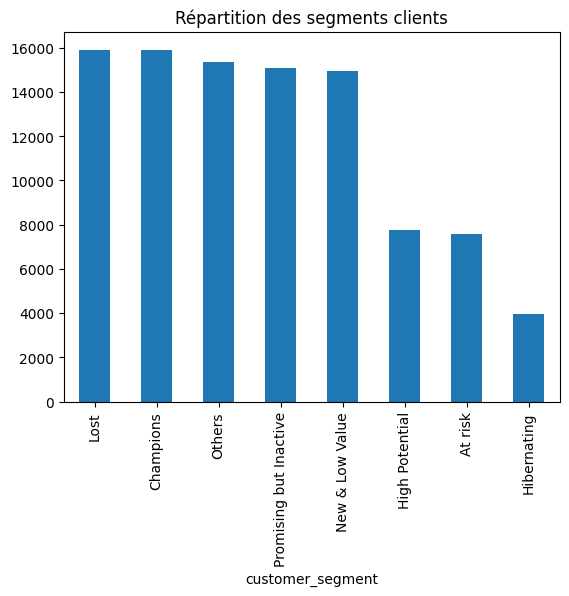

In [18]:
df_rm['customer_segment'].value_counts().plot(kind='bar',
                                              title='Répartition des segments clients')

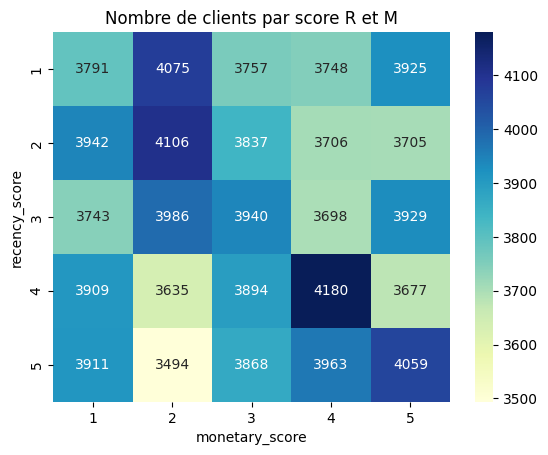

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_rm.pivot_table(index="recency_score", columns="monetary_score", values="customer_id", aggfunc="count")
sns.heatmap(pivot, annot=True, fmt="g", cmap="YlGnBu")
plt.title("Nombre de clients par score R et M")
plt.show()

In [20]:
#### 2. Analyse géographique des ventes
print(df_customers.columns)
def geographic_sales_analysis():
    """
    Analysez les performances par état/région

    Requêtes à écrire :
    1. Top 10 des états par CA
    2. Croissance MoM par région
    3. Taux de conversion par ville
    4. Distance moyenne vendeur-acheteur
    """

    query_top_states = """
    SELECT 
        c.customer_state,
        COUNT(DISTINCT o.order_id) AS total_orders,
        SUM(oi.price) AS total_sales,
        ROUND(AVG(oi.price)) AS avg_sales
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_state
    ORDER BY total_sales DESC
    LIMIT 10
    """

    return pd.read_sql(query_top_states, engine)

top_states = geographic_sales_analysis()
print(top_states)

Index(['customer_id', 'customer_city', 'customer_state'], dtype='object')
  customer_state  total_orders  total_sales  avg_sales
0             SP         40501   5067633.16      109.0
1             RJ         12350   1759651.13      124.0
2             MG         11354   1552481.83      120.0
3             RS          5345    728897.47      119.0
4             PR          4923    666063.51      118.0
5             SC          3546    507012.13      124.0
6             BA          3256    493584.14      134.0
7             DF          2080    296498.41      126.0
8             GO          1957    282836.70      124.0
9             ES          1995    268643.45      121.0


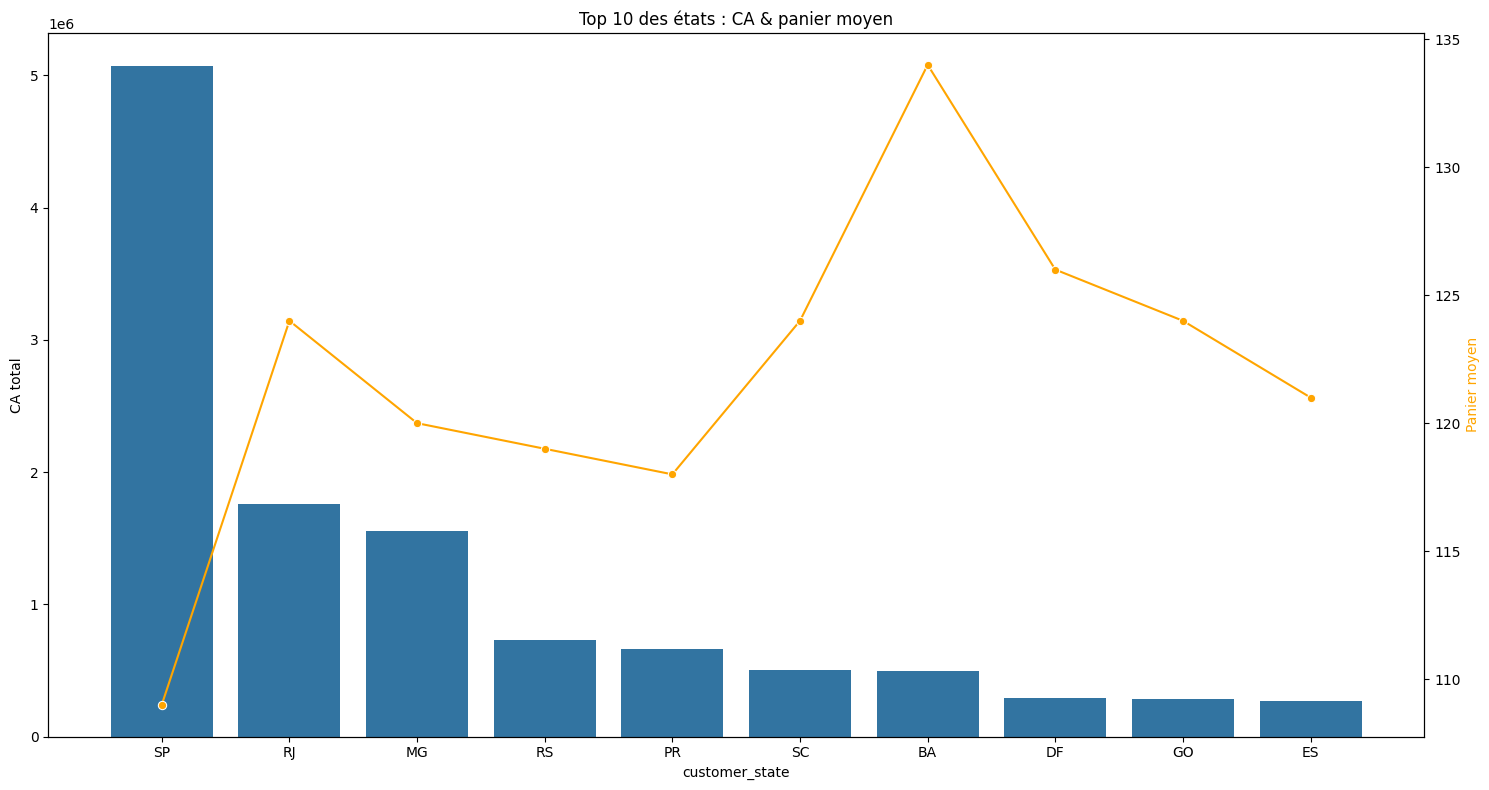

In [21]:
# Visualisation du CA (bar) et du panier moyen (twinx) par état
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()

# Barres : CA total
sns.barplot(data=top_states, x='customer_state', y='total_sales', ax=ax1)
ax1.set_ylabel('CA total')

# Ligne : panier moyen
sns.lineplot(data=top_states, x='customer_state', y='avg_sales', ax=ax2, color='orange', marker='o')
ax2.set_ylabel('Panier moyen', color='orange')

plt.title('Top 10 des états : CA & panier moyen')
plt.tight_layout()
plt.show()

Croissance Month-over-Month (MoM)

In [22]:
## Note :
# Je n'ai absolument pas produit cette requête seul, il y a beaucoup de fonctionnalité que je découvre (LAG, PARTITION BY...)
def get_mom_growth():
    """
    Calcule la croissance MoM du chiffre d'affaires par état (customer_state).
    Formule : (valeur actuelle - valeur précédente) * 100 / valeur précédente
    """
    query_mom = text("""
        WITH monthly_state_sales AS (
            SELECT
                c.customer_state,
                DATE_TRUNC('month', o.order_date) AS month,
                SUM(oi.price) AS total_sales
            FROM orders o
            JOIN order_items oi ON o.order_id = oi.order_id
            JOIN customers c ON o.customer_id = c.customer_id
            WHERE o.order_status = 'delivered'
            GROUP BY c.customer_state, DATE_TRUNC('month', o.order_date)
        ),
        mom_growth AS (
            SELECT
                customer_state,
                month,
                total_sales,
                LAG(total_sales) OVER (
                    PARTITION BY customer_state
                    ORDER BY month
                ) AS previous_sales,
                ROUND(
                    (total_sales - LAG(total_sales) OVER (
                        PARTITION BY customer_state
                        ORDER BY month
                    )) / NULLIF(LAG(total_sales) OVER (
                        PARTITION BY customer_state
                        ORDER BY month
                    ), 0) * 100, 2
                ) AS growth_rate_percent
            FROM monthly_state_sales
        )
        SELECT * FROM mom_growth
        ORDER BY customer_state, month;
    """)
    
    return pd.read_sql_query(query_mom, con=engine)

df_mom = get_mom_growth()
print(df_mom)


    customer_state      month  total_sales  previous_sales  \
0               AC 2017-01-01       589.60             NaN   
1               AC 2017-02-01       450.40          589.60   
2               AC 2017-03-01       455.99          450.40   
3               AC 2017-04-01      1162.38          455.99   
4               AC 2017-05-01      2094.39         1162.38   
..             ...        ...          ...             ...   
551             TO 2018-04-01      4291.82         4573.81   
552             TO 2018-05-01      2739.99         4291.82   
553             TO 2018-06-01      4049.42         2739.99   
554             TO 2018-07-01      2613.67         4049.42   
555             TO 2018-08-01      1925.97         2613.67   

     growth_rate_percent  
0                    NaN  
1                 -23.61  
2                   1.24  
3                 154.91  
4                  80.18  
..                   ...  
551                -6.17  
552               -36.16  
553         

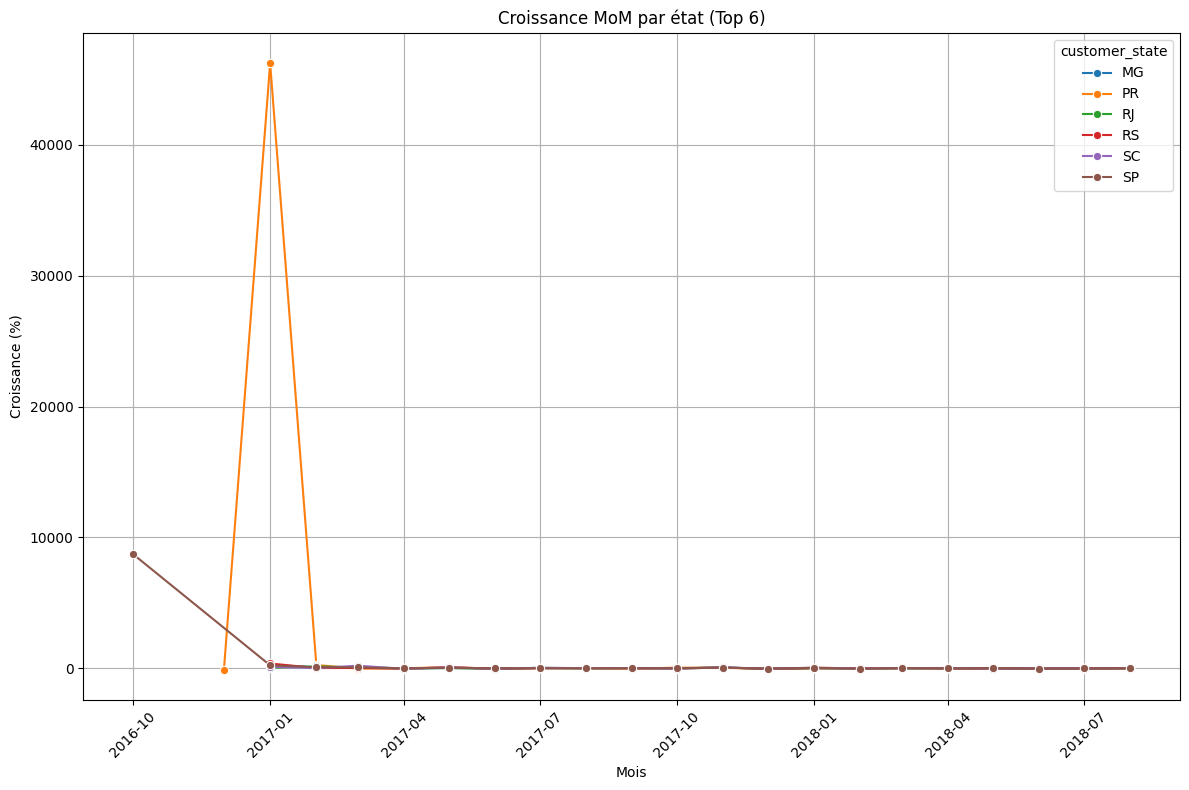

In [42]:
# On filtre les états avec le plus de données (ex : top 6 en volume total)
top_states = df_mom.groupby('customer_state')['total_sales'].sum().nlargest(6).index
df_filtered = df_mom[df_mom['customer_state'].isin(top_states)]

# On crée la figure
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_filtered,
    x='month',
    y='growth_rate_percent',
    hue='customer_state',
    marker='o'
)

plt.title("Croissance MoM par état (Top 6)")
plt.xlabel("Mois")
plt.ylabel("Croissance (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Calcul taux de conversion par ville
## dans une ville = (nombre de clients de la ville ayant passé au moins une commande) * 100 ÷ (nombre total de clients de la ville)
## Ensuite, on fait le taux de conversion par région (qui servira à la visualisation des données)
def get_convert_rate_with_state_avg():
    query = text("""
    WITH city_conversion AS (
        SELECT 
            c.customer_city,
            c.customer_state,
            COUNT(DISTINCT c.customer_id) AS total_customers,
            COUNT(DISTINCT CASE WHEN o.order_status = 'delivered' THEN c.customer_id END) AS customers_with_orders,
            ROUND(
                COUNT(DISTINCT CASE WHEN o.order_status = 'delivered' THEN c.customer_id END) * 100.0 
                / COUNT(DISTINCT c.customer_id), 2
            ) AS convert_rate
        FROM customers c
        LEFT JOIN orders o ON c.customer_id = o.customer_id
        GROUP BY c.customer_city, c.customer_state
    ),
    state_avg AS (
        SELECT
            customer_state,
            ROUND(AVG(convert_rate), 2) AS state_avg_convert_rate
        FROM city_conversion
        GROUP BY customer_state
    )
    SELECT 
        cc.*,
        sa.state_avg_convert_rate
    FROM city_conversion cc
    LEFT JOIN state_avg sa ON cc.customer_state = sa.customer_state
    ORDER BY convert_rate DESC NULLS LAST;
    """)
    return pd.read_sql_query(query, con=engine)

convert_rate_city_vs_state = get_convert_rate_with_state_avg()
print(convert_rate_city_vs_state.head())


  customer_city customer_state  total_customers  customers_with_orders  \
0        zortea             SC                2                      2   
1     abadiania             GO                1                      1   
2        abaete             MG               12                     12   
3    abaetetuba             PA               11                     11   
4       abaiara             CE                2                      2   

   convert_rate  state_avg_convert_rate  
0         100.0                   97.25  
1         100.0                   97.04  
2         100.0                   97.65  
3         100.0                   98.08  
4         100.0                   98.18  


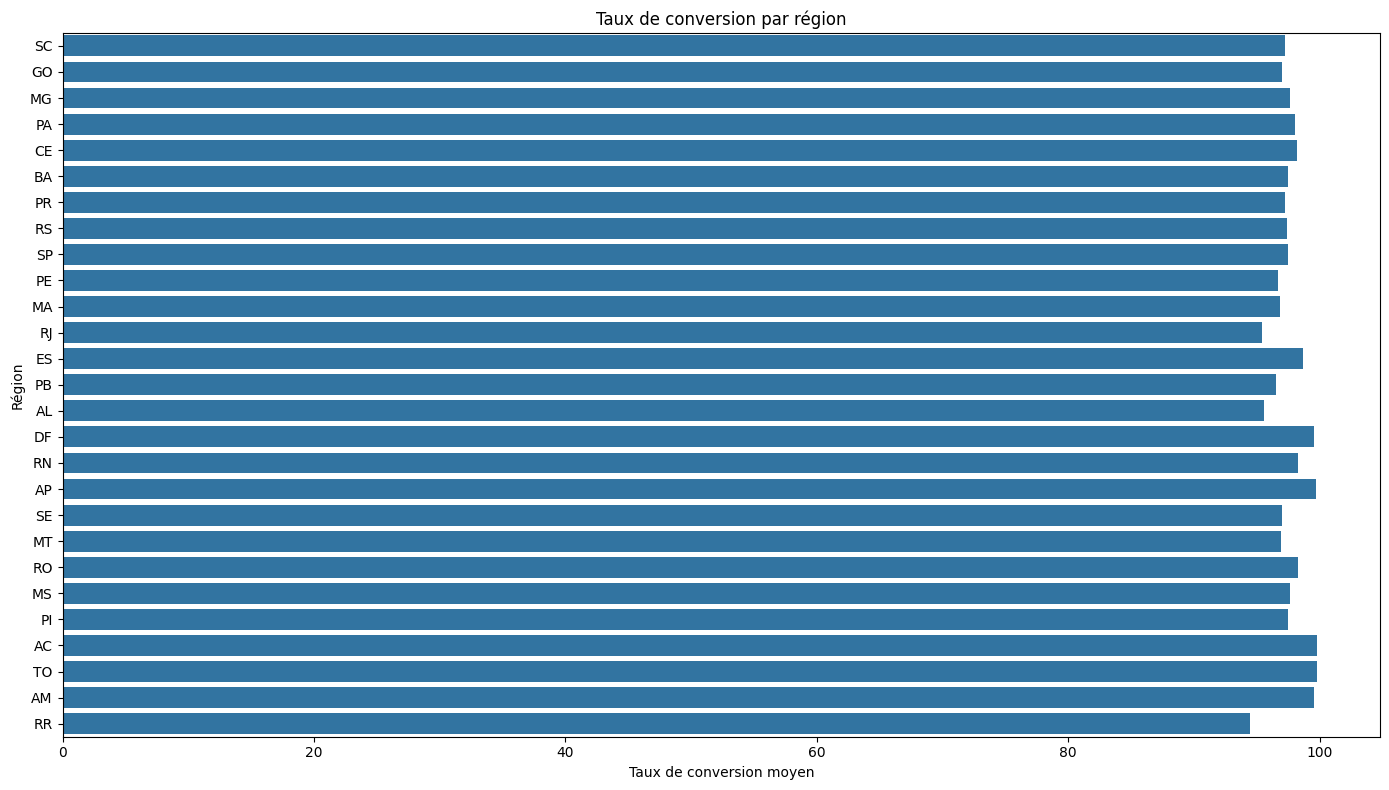

In [ ]:
# Visualisation (ma version)
## J'ai choisi de visualiser le taux de conversion par région plutôt que par ville car
## le nombre de villes est bien trop élevé pour être lisible sur un graphique.
plt.figure(figsize=(14, 8))
sns.barplot(data=convert_rate_city_vs_state,
            x='state_avg_convert_rate',
            y='customer_state',
            )
plt.xlabel('Taux de conversion moyen')
plt.ylabel('Région')
plt.title('Taux de conversion par région')
plt.tight_layout()
plt.show()

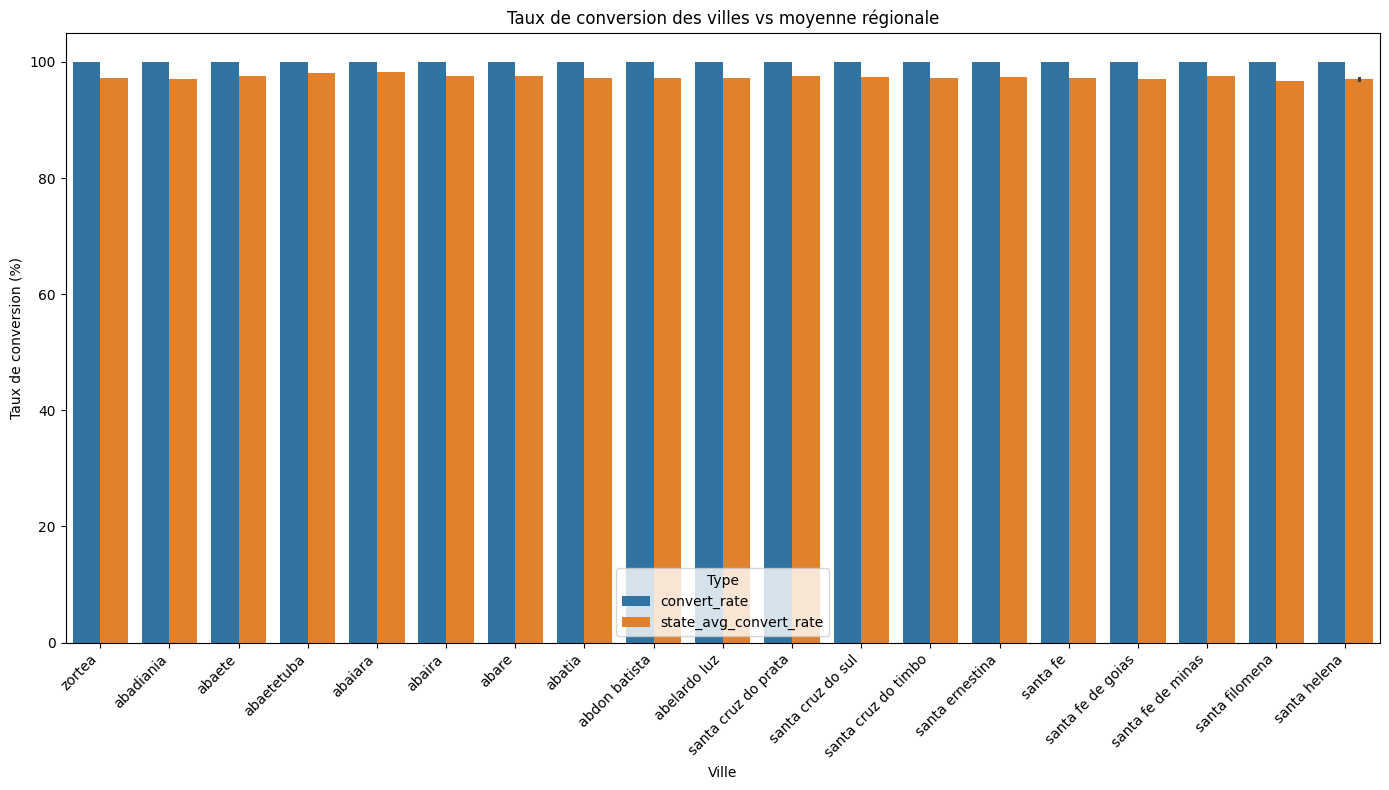

In [34]:
# Visualisation 2 (version aidée par chatgpt)
# Choisir un échantillon de villes (par exemple 20) pour ne pas surcharger
sample = convert_rate_city_vs_state.sort_values('convert_rate', ascending=False).head(20)

# Format long pour Seaborn
df_melted = sample.melt(id_vars=['customer_city', 'customer_state'], 
                        value_vars=['convert_rate', 'state_avg_convert_rate'],
                        var_name='Type', value_name='Rate')

# Tracer
plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted,
            x='customer_city', 
            y='Rate', 
            hue='Type')

plt.title("Taux de conversion des villes vs moyenne régionale")
plt.xlabel("Ville")
plt.ylabel("Taux de conversion (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 3. Analyse temporelle et saisonnalité
```sql
-- Détectez les patterns saisonniers
SELECT
    EXTRACT(YEAR FROM order_date) as year,
    EXTRACT(MONTH FROM order_date) as month,
    EXTRACT(DOW FROM order_date) as day_of_week,
    COUNT(*) as order_count,
    SUM(price + freight_value) as total_revenue,
    AVG(price + freight_value) as avg_order_value
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
WHERE order_status = 'delivered'
GROUP BY ROLLUP(
    EXTRACT(YEAR FROM order_date),
    EXTRACT(MONTH FROM order_date),
    EXTRACT(DOW FROM order_date)
)
ORDER BY year, month, day_of_week;
```

---

In [36]:
seasons_pattern_query = text("""
SELECT
    EXTRACT(YEAR FROM order_date) as year,
    EXTRACT(MONTH FROM order_date) as month,
    EXTRACT(DOW FROM order_date) as day_of_week,
    COUNT(*) as order_count,
    SUM(price + freight_value) as total_revenue,
    AVG(price + freight_value) as avg_order_value
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
WHERE order_status = 'delivered'
GROUP BY ROLLUP(
    EXTRACT(YEAR FROM order_date),
    EXTRACT(MONTH FROM order_date),
    EXTRACT(DOW FROM order_date)
)
ORDER BY year, month, day_of_week;
""")

seasons_pattern = pd.read_sql_query(seasons_pattern_query, con=engine)
print(seasons_pattern)

       year  month  day_of_week  order_count  total_revenue  avg_order_value
0    2016.0    9.0          4.0            3         143.46        47.820000
1    2016.0    9.0          NaN            3         143.46        47.820000
2    2016.0   10.0          0.0           26        2904.19       111.699615
3    2016.0   10.0          1.0           44        4456.26       101.278636
4    2016.0   10.0          2.0           63        9821.42       155.895556
..      ...    ...          ...          ...            ...              ...
171  2018.0    8.0          5.0         1003      135803.41       135.397218
172  2018.0    8.0          6.0          758      110963.05       146.389248
173  2018.0    8.0          NaN         7142      985491.64       137.985388
174  2018.0    NaN          NaN        60324     8451584.77       140.103189
175     NaN    NaN          NaN       110197    15419773.75       139.929161

[176 rows x 6 columns]


/tmp/ipykernel_854/3977954229.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_orders.index, y=weekly_orders.values, palette="viridis")


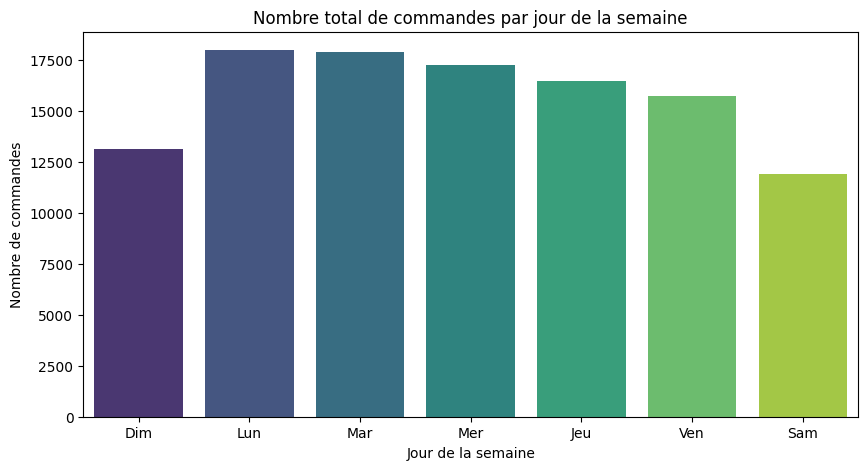

In [ ]:
## Visualisation des patterns selon la semaine et selon le mois 

# Copies
df_weekly = seasons_pattern.copy()
df_monthly = seasons_pattern.copy()

# Nettoyage des données

df_weekly = df_weekly[df_weekly['day_of_week'].notna()]
df_weekly['day_of_week'] = df_weekly['day_of_week'].astype(int)

df_monthly = df_monthly[df_monthly['month'].notna()]

# Mapping des noms des jours

day_names = ['Dim', 'Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam']
df_weekly['day_name'] = df_weekly['day_of_week'].apply(lambda x: day_names[int(x)])

# Agrégation par jour de semaine

weekly_orders = df_weekly.groupby('day_name', sort=False)['order_count'].sum().reindex(day_names)

# Visualisation du pattern selon les jours de la semaine
plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_orders.index, y=weekly_orders.values, palette="viridis")
plt.title("Nombre total de commandes par jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre de commandes")
plt.show()

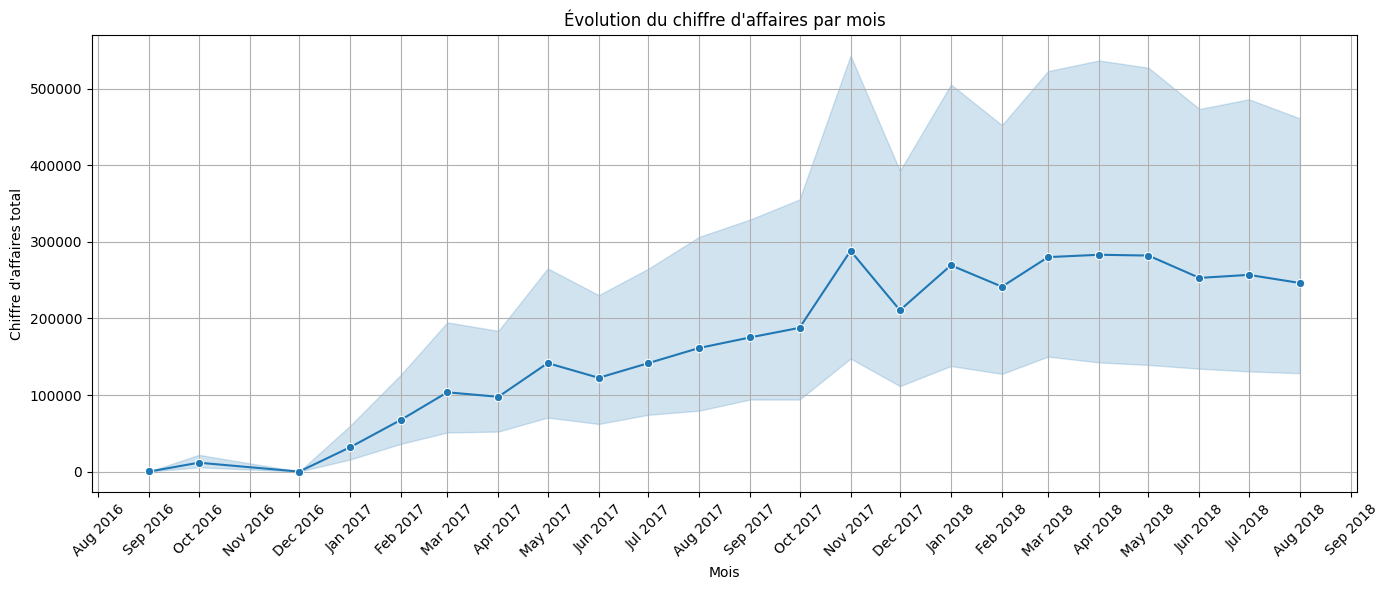

In [40]:
# Visualisation des pattern selon le mois

import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_monthly, x='date', y='total_revenue', marker='o')

plt.title("Évolution du chiffre d'affaires par mois")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires total")

# -- Affiche chaque mois sur l'axe X --
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Un tick tous les mois
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format 'Jan 2018'

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Partie 4 : Analyse prédictive avec SQL

### 🔮 Modèles simples en SQL

In [ ]:
#### 1. Prédiction de churn

def churn_prediction_sql():
    """
    Identifiez les clients à risque de churn

    Indicateurs :
    - Pas d'achat depuis X jours
    - Baisse de fréquence d'achat
    - Diminution du panier moyen
    - Changement de comportement géographique
    """

    churn_query = """
    WITH customer_activity AS (
        -- Calculez les métriques d'activité récente
        -- Comparez avec l'historique du client
        -- Scorez le risque de churn
    )

    SELECT
        customer_id,
        days_since_last_order,
        order_frequency_trend,
        monetary_trend,
        churn_risk_score,
        CASE
            WHEN churn_risk_score > 0.7 THEN 'High Risk'
            WHEN churn_risk_score > 0.4 THEN 'Medium Risk'
            ELSE 'Low Risk'
        END as churn_segment
    FROM customer_activity;
    """

    return pd.read_sql(churn_query, engine)

churn_predict = churn_prediction_sql()

print(churn_predict)


In [48]:
# Calcul des métriques d'activité récente
## Je reprends le calcul de récence 

recent_activity = text("""
SELECT 
    customer_id, 
    MAX(order_date) AS last_order_date,
    DATE_PART('day', :ref_date - MAX(o.order_date)) AS days_from_last_order
FROM orders
GROUP BY customer_id
""")

results = pd.read_sql_query(recent_activity, con=engine)
print(results)

StatementError: (sqlalchemy.exc.InvalidRequestError) A value is required for bind parameter 'ref_date'
[SQL: 
SELECT 
    customer_id, 
    MAX(order_date) AS last_order_date,
    DATE_PART('day', %(ref_date)s - MAX(o.order_date)) AS days_from_last_order
FROM orders
GROUP BY customer_id
]
(Background on this error at: https://sqlalche.me/e/20/cd3x)

#### 2. Recommandations produits
```sql
-- Market Basket Analysis simplifié
WITH product_pairs AS (
    SELECT
        oi1.product_id as product_a,
        oi2.product_id as product_b,
        COUNT(*) as co_purchase_count
    FROM order_items oi1
    JOIN order_items oi2 ON oi1.order_id = oi2.order_id
    WHERE oi1.product_id != oi2.product_id
    GROUP BY oi1.product_id, oi2.product_id
    HAVING COUNT(*) >= 10  -- Seuil minimum
)

SELECT
    product_a,
    product_b,
    co_purchase_count,
    co_purchase_count::float / total_a.count as confidence
FROM product_pairs pp
JOIN (
    SELECT product_id, COUNT(*) as count
    FROM order_items
    GROUP BY product_id
) total_a ON pp.product_a = total_a.product_id
ORDER BY confidence DESC;
```

---

## Partie 5 : Intégration avec les APIs météo

### 🌤️ Croisement données météo/ventes
```python
def weather_sales_correlation():
    """
    Correlez vos données météo du Notebook 1 avec les ventes
    
    Hypothèses à tester :
    1. Les ventes de certaines catégories augmentent-elles avec la pluie ?
    2. Y a-t-il un impact de la température sur les achats ?
    3. Les livraisons sont-elles impactées par la météo ?
    """
    
    # Récupérez les données météo historiques pour les villes brésiliennes
    weather_query = """
    SELECT DISTINCT customer_city, customer_state
    FROM customers
    WHERE customer_state IN ('SP', 'RJ', 'MG', 'RS', 'SC')
    ORDER BY customer_city;
    """
    
    cities = pd.read_sql(weather_query, engine)
    
    # Intégrez avec l'API météo
    # Analysez les corrélations
    
    pass
```

In [1]:
# Compter le nombre de commandes par ville

orders_per_city = text("""
SELECT 
                       COUNT(DISTINCT o.order_id) AS total_orders,
                       c.customer_city,
FROM orders o
JOIN customers c ON c.order_id = o.order_id
GROUP BY c.customer_city
ORDER BY o.order_id DESC;
""")
df_order_per_city = pd.read_sql_query(orders_per_city, con=engine)
print(df_order_per_city)

NameError: name 'text' is not defined

### 📊 Dashboard géo-temporel
```python
def create_geotemporal_dashboard():
    """
    Créez un dashboard interactif combinant :
    - Carte des ventes par région
    - Évolution temporelle avec météo
    - Segments clients géolocalisés
    - Prédictions par zone géographique
    """
    pass
```

---
## 🏆 Livrables finaux

### 📈 Rapport d'analyse complet
1. **Segmentation RFM (Recency, Frenquency, Monetary) ** : 5-7 segments avec caractéristiques
2. **Analyse géographique**  : Performances par région + recommandations
3. **Prédictions churn** : Liste des clients à risque + actions
4. **Recommandations produits** : Top 10 des associations
5. **Impact météo** : Corrélations significatives identifiées

### 🚀 Pipeline automatisé
```python
def automated_analysis_pipeline():
    """
    Pipeline qui :
    1. Se connecte à la DB
    2. Exécute toutes les analyses
    3. Met à jour les segments clients
    4. Génère le rapport automatiquement
    5. Envoie des alertes si nécessaire
    """
    pass
```

---

## 🎓 Auto-évaluation

- [ ] **Connexion DB** : PostgreSQL fonctionnelle
- [ ] **Requêtes complexes** : JOINs, CTEs, fonctions analytiques
- [ ] **Gestion des erreurs** : Connexions robustes
- [ ] **Performance** : Requêtes optimisées avec index
- [ ] **Intégration** : SQL + Python + APIs
- [ ] **Insights actionables** : Recommandations business claires

### 🔗 Préparation au Notebook 3
Le prochain notebook portera sur NoSQL (MongoDB) avec des données de réseaux sociaux et d'IoT, en temps réel.

### 💡 Bases de données alternatives
- **PlanetScale** : MySQL serverless gratuit
- **MongoDB Atlas** : 512MB gratuit
- **FaunaDB** : Base multi-modèle gratuite
- **Hasura Cloud** : GraphQL + PostgreSQL